# Explanation of Step 4: Marker Stability / Jitter Analysis

### a. What this code is about
This code measures the **"shakiness"** or **"wobble"** of each tracked body part (marker) across consecutive frames. This shakiness is called **"jitter"**.

In simple terms, it checks: **"How much does this marker jump around from one frame to the next, even when the real animal isn't moving that fast?"**

It reads the raw $x, y$ coordinates from the tracking files (`.analysis.h5`) and calculates two main metrics of instability: **Delta ($\Delta$) Pixel** and **Residual Jitter**.

---
### b. How it works (Methodology)
1.  **Input:** It loads the $x, y$ coordinates for all markers and frames from the **SLEAP analysis files** (`.analysis.h5`) for each camera.
2.  **$\Delta$ Pixel (Frame-to-Frame Change):**
    * For every marker, it calculates the **distance** (in pixels) the marker moved between frame $t$ and frame $t+1$. This is the $\Delta$ Pixel, or **`deltas`**.
    * A **high median $\Delta$ Pixel** means the marker is jumping a lot between frames, suggesting jitter or poor localization.
3.  **Residual Jitter:**
    * It first creates a **smoothed version** of the marker's path by using a moving average (`smooth_window=5`).
    * The **`residual`** is the distance between the **raw, choppy path** and the **smoothed path**.
    * A **high residual jitter** means the raw data is very noisy compared to the likely true, smooth movement.
4.  **Heatmap and Top-K Plots:**
    * It summarizes the results in a table and then creates a **heatmap** for quick visualization of the jitter across all cameras and nodes.
    * Crucially, it identifies the **top $K$ (e.g., $K=5$) worst-performing markers** based on the median $\Delta$ Pixel and saves detailed time-series plots for each one.

---
### c. Output it produces (Output files)
This code creates a new folder structure: `...\metrics_step4\`

Inside this folder, it saves **two CSV files**, **one main PNG plot**, and an additional folder with more plots:

* `jitter_by_cam_node.csv`
* `jitter_top_issues.csv`
* `jitter_heatmap.png`
* **A new folder:** `top_series/` which contains `top01__...png` up to `top05__...png`.

---
### d. What each file means?

* `jitter_by_cam_node.csv`:
    * This is the **main results table**. Each row is one `(cam, node)` pair.
    * **`median_delta_px`**: The typical (median) distance the marker moves between two consecutive frames. **This is the primary jitter measure.**
    * **`p95_delta_px`**: The distance moved in the 95th percentile (i.e., $95\%$ of the moves are smaller than this value). Useful for finding extreme jumps.
    * **`residual_jitter_px`**: The median distance between the raw marker position and its short-term smoothed path.

* `jitter_top_issues.csv`:
    * The same data as above, but **sorted** to show the markers with the **highest median $\Delta$ Pixel** at the top.

* `jitter_heatmap.png`:
    * A grid where colors show the **`median_delta_px`** for every marker and camera. Bright or dark cells indicate severe jitter. The contrast is stretched using a $95^{th}$ percentile cap to make small differences easier to see.

* `top_series/topXX__...png` files:
    * These are the detailed plots for the **$K$ worst-jittering markers**. They show the $\Delta$ Pixel for *every* single frame, which helps you see if the jitter is constant noise or happens in sudden bursts.

---
### e. Console output types and what each means?
* `[OK] wrote: ...`: Success messages confirming that each CSV file and PNG plot (including the $K$ time-series plots) was successfully saved to the output folder.
* `=== Quick Summary (top 8 by median Δpx) ===`: The final, most useful summary. It prints the top 8 worst-jittering pairs with their three key metrics (`median Δ`, `p95`, `residual ≈`) right to your screen for an instant diagnosis.

---
### f. How this code helps us
This code helps you find **unreliable markers** caused by poor tracking.

If a body part is showing **high jitter** (high median $\Delta$ px), it means the tracking algorithm is having trouble localizing that point accurately, even when the animal is barely moving. This results in:
* **Noisy Kinematics:** Any speed or acceleration calculations based on this marker will be full of errors.
* **Diagnosis:** High jitter can point to specific problems like:
    * A **marker being hidden** or having low visual contrast.
    * An **overly sensitive model** that needs more training examples in that specific area.
    * A **poorly defined body part** that the model can't consistently find.

### Hyperparameters (what they mean and why they matter)

- `smooth_window = 5`
  - We build a short moving average over 5 frames to estimate a "smooth" path for each marker.
  - Then we compare the raw marker vs that smooth path to get `residual_jitter_px`.
  - Smaller window = we only smooth a tiny bit (very local), so we still see real motion and we only remove ultra-high-frequency buzz.
  - If you make this huge (like 50), the "smooth path" becomes too slow and `residual_jitter_px` will look bigger because normal motion will now look like "wobble."
  - So 5 means: just kill instant pixel buzz, don't erase actual movement.

- `top_k_series = 5`
  - After ranking all (camera, marker) pairs by worst jitter, we only plot the worst K of them.
  - K = 5 means: save 5 PNG time-series plots for the worst 5 offenders.
  - If you set 10, you'll get top10 plots instead. This doesn't change the math, just how many plots you export.

- `series_roll_w = 301`
  - This is ONLY for the orange line in the jitter plots.
  - We take a rolling median with a big window (301 frames) to show the general trend of jitter over time.
  - The blue curve is the raw per-frame Δpx. The orange curve is the slow trend.
  - This does NOT affect the numbers in the CSV. It's just to make the plot readable.
  - If you make this smaller (like 31), the orange line will wiggle more and look noisy. If you make it bigger (like 1001), it will look super flat.

- `colormap_name = "viridis"`
  - This chooses the color map for the heatmap.
  - `"viridis"`, `"turbo"`, `"cividis"`, `"magma"` are just different color styles.
  - This only affects visualization. It does NOT affect any numeric result.

Summary:
- `smooth_window` affects how we measure residual jitter.
- `top_k_series` is how many worst plots we save.
- `series_roll_w` affects only the orange helper line in those plots.
- `colormap_name` affects only the heatmap colors.

Changing these will not "cheat" the core honesty of median Δpx and p95 Δpx. Those main stability numbers stay the same.


[OK] wrote: ../results\Evaluation Metrics\metrics_step4\jitter_by_cam_node.csv
[OK] wrote: ../results\Evaluation Metrics\metrics_step4\jitter_top_issues.csv


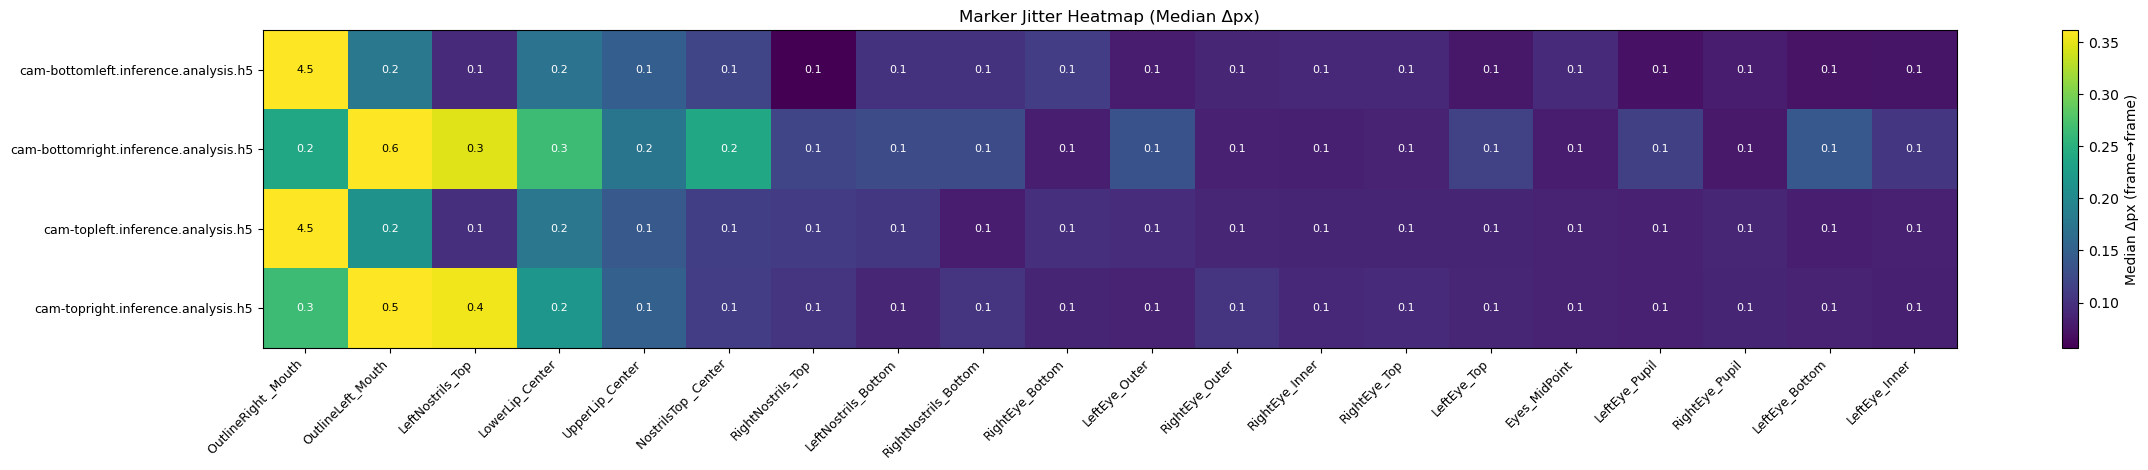

[OK] wrote: ../results\Evaluation Metrics\metrics_step4\jitter_heatmap.png
[OK] wrote: ../results\Evaluation Metrics\metrics_step4\top_series\top01__cam-bottomleft.inference.analysis.h5__OutlineRight__Mouth.png
[OK] wrote: ../results\Evaluation Metrics\metrics_step4\top_series\top02__cam-topleft.inference.analysis.h5__OutlineRight__Mouth.png
[OK] wrote: ../results\Evaluation Metrics\metrics_step4\top_series\top03__cam-bottomright.inference.analysis.h5__OutlineLeft_Mouth.png
[OK] wrote: ../results\Evaluation Metrics\metrics_step4\top_series\top04__cam-topright.inference.analysis.h5__OutlineLeft_Mouth.png
[OK] wrote: ../results\Evaluation Metrics\metrics_step4\top_series\top05__cam-topright.inference.analysis.h5__LeftNostrils_Top.png

=== Quick Summary (top 8 by median Δpx) ===
cam-bottomleft.inference.analysis.h5 :: OutlineRight _Mouth: median Δ=4.47px, p95=9.90px, residual≈2.04px
cam-topleft.inference.analysis.h5 :: OutlineRight _Mouth: median Δ=4.45px, p95=13.60px, residual≈1.75px
cam

In [10]:
# === STEP 4 (Marker Stability / Jitter) — CLEAN + TOP5 SERIES ===
# - Better heatmap colors + contrast
# - Save time-series plots for the worst K cam×node pairs (legit results)

import os, glob, warnings
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

# ---------- USER SETTINGS ----------
session_dir   = r"/Users/howardwang/Desktop/Ruten/Evaluation-Metrics_Vishal-main/face/results/n20/phase1_temp_session"
out_root      = r"/Users/howardwang/Desktop/Ruten/Evaluation-Metrics_Vishal-main/face/results/n20"
smooth_window = 5    # frames for residual jitter
top_k_series  = 5    # NEW: how many worst pairs to plot and save
series_roll_w = 301  # NEW: rolling median window for nicer, continuous-ish series
colormap_name = "viridis"  # NEW: try "turbo", "viridis", "cividis", "magma"
# -----------------------------------

def _maybe_decode(x):
    if isinstance(x, (bytes, bytearray, np.bytes_)):
        return x.decode("utf-8", errors="ignore")
    return str(x)

def find_cam_h5s(session_dir: str):
    h5s = sorted(glob.glob(os.path.join(session_dir, "*.analysis.h5")))
    if not h5s:
        raise RuntimeError(f"No *.analysis.h5 files found in {session_dir}")
    return {os.path.basename(p): p for p in h5s}

def load_sleap_analysis_h5(path: str):
    with h5py.File(path, "r") as f:
        node_names = None
        for k in ["node_names","nodes","points/labels"]:
            if k in f:
                node_names = [_maybe_decode(a) for a in np.array(f[k]).ravel()]
                break

        ds = None
        for cand in ["tracks","pred_points","points"]:
            if cand in f: ds = f[cand]; break
        if ds is None: raise RuntimeError(f"No predicted points dataset in {path}")
        arr = np.array(ds)

        # normalize -> (K,T,N,2)
        if arr.ndim == 4:
            s = arr.shape
            if s[1]==2 and s[-1]>50: arr = arr.transpose(0,3,2,1)
            elif s[2]==2 and s[0]>50: arr = arr.transpose(3,0,1,2)
            elif s[-1]==2: pass
            elif s[0]==2: arr = arr.transpose(3,2,1,0)
            else:
                dims=list(arr.shape)
                coord_ax=int(np.where(np.array(dims)==2)[0][0])
                frame_ax=int(np.argmax(dims))
                cands=[i for i in range(4) if i not in (coord_ax,frame_ax)]
                k_ax=cands[int(np.argmin([dims[i] for i in cands]))]
                n_ax=[i for i in range(4) if i not in (coord_ax,frame_ax,k_ax)][0]
                arr = arr.transpose(k_ax, frame_ax, n_ax, coord_ax)
        elif arr.ndim==3 and arr.shape[-1]==2:
            arr = arr[None, ...]
        else:
            raise RuntimeError(f"Unrecognized array shape {arr.shape}")

        K,T,N,_ = arr.shape

        # best track by occupancy if present
        kbest = 0
        for k in ["track_occupancy","tracks_occupancy","occupancy"]:
            if k in f:
                o = np.array(f[k])
                if o.ndim==3: occ=o.reshape(K,T,-1).max(-1)
                elif o.ndim==2: occ=o if o.shape[0]==K else o.T
                else: occ=None
                if occ is not None: kbest = int(np.argmax(occ.sum(axis=1)))
                break

        pts = arr[kbest].astype(float)  # (T,N,2)

        # mask low-confidence frames if scores exist
        for k in ["point_scores","points_scores","node_scores","point_confidences","scores"]:
            if k in f:
                sc = np.array(f[k])
                if sc.ndim==4 and sc.shape[0]==K: sc=sc[kbest]
                sc = np.squeeze(sc)
                if sc.ndim==3 and sc.shape[-1] in (1,2): sc = sc[...,0]
                elif sc.ndim==2 and sc.shape[0]==N and sc.shape[1]==T: sc = sc.T
                elif sc.ndim==1 and sc.shape[0]==N: sc = np.tile(sc[None,:], (T,1))
                elif sc.ndim==1 and sc.shape[0]==T: sc = np.tile(sc[:,None], (1,N))
                else: sc=None
                if sc is not None:
                    bad = ~np.isfinite(sc) | (sc<=0)
                    pts[bad] = np.nan
                break

        if node_names is None:
            node_names=[f"node_{i}" for i in range(pts.shape[1])]
        return pts, node_names

def moving_average_1d_per_node(a, w):
    if w <= 1: return a.copy()
    T,N,_ = a.shape
    out = np.empty_like(a)
    half = w//2
    kernel = np.ones(w)/w
    for j in range(N):
        for c in range(2):
            col = a[:,j,c].copy()
            for t in range(1,T):
                if not np.isfinite(col[t]) and np.isfinite(col[t-1]):
                    col[t] = col[t-1]
            if not np.isfinite(col).any():
                out[:,j,c] = np.nan; continue
            padded = np.pad(col, (half,half), mode="edge")
            sm = np.convolve(padded, kernel, mode="same")[half:-half]
            out[:,j,c] = sm
    return out

# ------------ MAIN ------------
cams = find_cam_h5s(session_dir)
out_dir = os.path.join(out_root, os.path.basename(os.path.normpath(session_dir)), "metrics_step4")
os.makedirs(out_dir, exist_ok=True)

rows = []
series_bank = {}  # NEW: store deltas per cam×node for later plotting

for cam_key, h5p in cams.items():
    pts, node_names = load_sleap_analysis_h5(h5p)   # (T,N,2)
    T, N = pts.shape[0], pts.shape[1]

    dx = np.diff(pts[:,:,0], axis=0)
    dy = np.diff(pts[:,:,1], axis=0)
    deltas = np.sqrt(dx*dx + dy*dy)                 # (T-1, N)

    sm = moving_average_1d_per_node(pts, w=smooth_window)
    residual = np.sqrt(((pts - sm)**2).sum(axis=2)) # (T,N)

    for j, name in enumerate(node_names):
        d = deltas[:, j]; d = d[np.isfinite(d)]
        r = residual[:, j]; r = r[np.isfinite(r)]

        med = float(np.median(d)) if d.size else np.nan
        p95 = float(np.percentile(d,95)) if d.size else np.nan
        rmed= float(np.median(r)) if r.size else np.nan

        rows.append(dict(
            cam=cam_key, node=name,
            median_delta_px=med, p95_delta_px=p95,
            residual_jitter_px=rmed, n_frames=int(T)
        ))

        # NEW: keep raw delta series for potential top-K plotting
        series_bank[(cam_key, name)] = deltas[:, j]  # keep NaNs; we’ll handle in plotting

df = pd.DataFrame(rows)

# Save CSVs
jitter_csv = os.path.join(out_dir, "jitter_by_cam_node.csv")
df.to_csv(jitter_csv, index=False)
print("[OK] wrote:", jitter_csv)

top_sorted = df.sort_values("median_delta_px", ascending=False)
top_csv = os.path.join(out_dir, "jitter_top_issues.csv")
top_sorted.head(8).to_csv(top_csv, index=False)
print("[OK] wrote:", top_csv)

# ---------- HEATMAP (better colors/contrast) ----------
node_order = (
    df.groupby("node")["median_delta_px"]
      .median()
      .sort_values(ascending=False)
      .index.tolist()
)
cam_order = sorted(df["cam"].unique().tolist())

heatmat = np.full((len(cam_order), len(node_order)), np.nan)
for i,c in enumerate(cam_order):
    for j,n in enumerate(node_order):
        sub = df[(df["cam"]==c) & (df["node"]==n)]["median_delta_px"]
        if len(sub): heatmat[i,j] = float(sub.iloc[0])

plt.figure(figsize=(1.0*len(node_order)+4, 0.7*len(cam_order)+2))

# Stretch contrast by capping vmax at 95th percentile (so small values separate better)
finite_vals = heatmat[np.isfinite(heatmat)]
vmin = np.nanmin(finite_vals) if finite_vals.size else 0.0
vmax_raw = np.nanmax(finite_vals) if finite_vals.size else 1.0
vmax = np.percentile(finite_vals, 95) if finite_vals.size else vmax_raw
if vmax < vmax_raw: vmax = vmax  # cap high outliers
else: vmax = vmax_raw

norm = Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap(colormap_name)  # "turbo"/"viridis"/"cividis"/"magma"

im = plt.imshow(heatmat, aspect="auto", norm=norm, cmap=cmap)
plt.colorbar(im, label="Median Δpx (frame→frame)")
plt.xticks(range(len(node_order)), node_order, rotation=45, ha="right", fontsize=9)
plt.yticks(range(len(cam_order)), cam_order, fontsize=9)
plt.title("Marker Jitter Heatmap (Median Δpx)")

# annotate with readable text (auto black/white depending on luminance)
for i in range(len(cam_order)):
    for j in range(len(node_order)):
        val = heatmat[i,j]
        if np.isfinite(val):
            rgba = cmap(norm(min(val, vmax)))  # respect capped vmax for luminance
            lum = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
            txt_color = "black" if lum > 0.6 else "white"
            plt.text(j, i, f"{val:.1f}", ha="center", va="center", fontsize=8, color=txt_color)

plt.tight_layout()
heatmap_path = os.path.join(out_dir, "jitter_heatmap.png")
plt.savefig(heatmap_path, dpi=220)
plt.show()
print("[OK] wrote:", heatmap_path)

# ---------- TOP-K SERIES PLOTS (legit results, not examples) ----------

import re

def sanitize_filename(s: str) -> str:
    """
    Make a safe filename for Windows:
    - replace spaces with '_'
    - remove characters that Windows can't handle: \ / : * ? " < > |
    - optionally clip length if it's crazy long
    """
    s = s.replace(" ", "_")
    s = re.sub(r'[\\/:*?"<>|]+', '_', s)
    # also collapse double underscores just to keep it clean
    s = re.sub(r'__+', '__', s)
    return s[:150]  # safety limit

series_dir = os.path.join(out_dir, "top_series")
os.makedirs(series_dir, exist_ok=True)

def rolling_median(arr, w):
    import pandas as _pd
    s = _pd.Series(arr)
    if w % 2 == 0:
        w += 1
    return s.rolling(
        window=w,
        center=True,
        min_periods=max(5, w//5)
    ).median().to_numpy()

for rank, (_, row) in enumerate(top_sorted.head(top_k_series).iterrows(), start=1):
    cam_name  = str(row["cam"])
    node_name = str(row["node"])
    key = (cam_name, node_name)

    series = series_bank.get(key)
    if series is None:
        continue

    xs = np.arange(len(series))
    rmed = rolling_median(series, series_roll_w)

    plt.figure(figsize=(10,3))
    plt.plot(xs, series, linewidth=0.7, alpha=0.6, label="Δpx (raw)")
    plt.plot(xs, rmed, linewidth=2.0, label=f"rolling median (w={series_roll_w})")
    plt.xlabel("Frame index (t → t+1 deltas)")
    plt.ylabel("Δpx")

    ttl = (
        f"[{rank}/{top_k_series}] Jitter — {cam_name} :: {node_name} | "
        f"median={row['median_delta_px']:.2f}px, "
        f"p95={row['p95_delta_px']:.2f}px, "
        f"residual≈{row['residual_jitter_px']:.2f}px"
    )
    plt.title(ttl)
    plt.legend(loc="upper right")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # make a safe filename for Windows
    fname_cam  = sanitize_filename(cam_name)
    fname_node = sanitize_filename(node_name)
    outp = os.path.join(
        series_dir,
        f"top{rank:02d}__{fname_cam}__{fname_node}.png"
    )

    plt.savefig(outp, dpi=160)
    plt.close()
    print("[OK] wrote:", outp)


# ---------- CONSOLE SUMMARY ----------
print("\n=== Quick Summary (top 8 by median Δpx) ===")
for _, r in top_sorted.head(8).iterrows():
    print(f"{r['cam']} :: {r['node']}: median Δ={r['median_delta_px']:.2f}px, "
          f"p95={r['p95_delta_px']:.2f}px, residual≈{r['residual_jitter_px']:.2f}px")


### How to read the jitter numbers

For each (camera, marker) pair we report 3 key numbers:

1. **median Δ (px)**  
   - This is the *typical* frame-to-frame jump size.
   - We look at how far the marker moved between frame t and frame t+1 for the whole video.
   - Then we take the median of those jumps.
   - High median Δ means the point is "dancing" every frame (bad stability).
   - Low median Δ means the point is staying steady unless the animal really moves (good).

   Example: `median Δ = 4.47 px`  
   → In a normal frame step, this marker is jumping about 4.47 pixels.  
   → That's pretty jumpy.

2. **p95 (px)**  
   - This is the 95th percentile of the jumps.
   - "In the worst 5% of frames, how big were the jumps?"
   - It tells you how bad the spikes get.

   Example: `p95 = 9.90 px`  
   → The worst spikes in that marker are ~10 pixels per frame.  
   → That means sometimes the tracker basically teleports that point.

   Rule of thumb:  
   - If p95 is much bigger than median Δ, the marker has rare but very violent glitches.

3. **residual (px)** (shown as `residual≈...px`)
   - We build a short smooth path of where the marker *should* be (using a tiny 5-frame average).
   - Then we measure how far the raw marker is from that smooth path.
   - This captures tiny buzzing/wobble even if the point isn't jumping huge distances.

   Example: `residual ≈ 2.04 px`  
   → On average, the raw point is ~2 pixels away from its own smoothed path.  
   → So even when it's "on target", it's still vibrating around by ~2 px.

---

### How to interpret all three together
Using: `median Δ=4.47px, p95=9.90px, residual≈2.04px`

- median Δ = 4.47 px → baseline jitter per frame is already high.
- p95 = 9.90 px → sometimes it explodes and jumps ~10 px in one step.
- residual ≈ 2.04 px → even inside steady regions, it's wobbling ~2 px around its local path.

This marker is unstable. It will contaminate any angle/velocity you compute from it.
